# UCI Introduction to Machine Learning
**Day 3: Transformers**


Notebook adapted by Gage DeZoort from a similar notebook offered in Princeton University's [Introduction to Machine Learning Wintersession course](https://github.com/PrincetonUniversity/intro_machine_learning/tree/main).



<a href="https://colab.research.google.com/github/GageDeZoort/intro_ml_uci/blob/main/day_3/intro_to_ML_day_3_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Imports

In [1]:
%matplotlib inline

!pip install datasets -q




The goal of this tutorial is to train a sequence-to-sequence



## 1. Tokens for Language Modeling





Given a word or sequence of words, how likely is some subsequent word? This is a fundamental language modeling task: assigning a likelihood probability to a word to follow some input sequence.


As an example, let's consider the following input sequence:

*I need to take my dog to the vet because he is*

What's the next word? *Hungry*? *Healthy*? *Sick*?

You get the picture.

### 1.1 Tokenization

Machines need to analyze **tokenized** data. Tokens can be words, phrases, characters, etc. They have corresponding `IDs` that are stored in a lookup table.

We're going to use a model called *BERT* (Bidirectional Transformers) as our tokenizer. BERT is a transformer model, whose tokenizer splits the input text into words and punctuation, ignoring whitespace. It also splits complicated words into subwords. See below how the string `"deeeep"` which does not appear in the English language, is split into three tokens `['dee', '##ee', '##p']`. The latter two tokens are called *subwords*.

Google's propriatary WordPiece algorithm is used to build BERT's vocabulary (of subwords) built iteratively from an initial vocab of single character tokens. Frequent character pairs are merged into new subwords until its 30,000 token vocabulary is constructed.





In [2]:
from transformers import AutoTokenizer

# Choose a pre-trained model tokenizer (e.g., BERT)
model_name = "bert-base-uncased" # 100M parameters, not case-sensitive
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Example: Tokenizing text
text = "Transformers are a type of deeeep learning model used for NLP tasks. Epehmeral. Anachronism."
tokens = tokenizer.tokenize(text)
print("Tokens:", tokens)

# Converting tokens to IDs
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Token IDs:", token_ids)

# Decoding token IDs back to text
decoded_text = tokenizer.decode(token_ids)
print("Decoded Text:", decoded_text)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokens: ['transformers', 'are', 'a', 'type', 'of', 'dee', '##ee', '##p', 'learning', 'model', 'used', 'for', 'nl', '##p', 'tasks', '.', 'ep', '##eh', '##meral', '.', 'ana', '##ch', '##ron', '##ism', '.']
Token IDs: [19081, 2024, 1037, 2828, 1997, 9266, 4402, 2361, 4083, 2944, 2109, 2005, 17953, 2361, 8518, 1012, 4958, 11106, 28990, 1012, 9617, 2818, 4948, 2964, 1012]
Decoded Text: transformers are a type of deeeep learning model used for nlp tasks. epehmeral. anachronism.


### 1.2 Sequence Data


To create a coherent learning task, we need to take sequences of tokens and batch them into inputs with corresponding targets. Sequences are batched into uniform-length chunks. For example consider two words written as sequences of tokens:

Sequence #1: `["run", "##ner"]`

Sequence #2: `["d", "##run", "#k", "##en"]`

Our model will expect fixed-size sequences at input, say of size `max_length=3`. Sequence #1 is shorter than `max_length`, so we have to *pad* it with some default value. In BERT, this default value is `[PAD]`. Sequence #2, on the other hand, is longer than `max_length`, so we have to *truncate* it.

In [3]:
# Padding and truncation

sequence = tokenizer(text, padding="max_length", truncation=True, max_length=10)
print("Encoded Sequence:", sequence)
tokenizer.decode(sequence["input_ids"])

Encoded Sequence: {'input_ids': [101, 19081, 2024, 1037, 2828, 1997, 9266, 4402, 2361, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


'[CLS] transformers are a type of deeeep [SEP]'

Here, the `input_IDs` are what the BERT transformer will actually process, the `token_type_ids` are used to demarkate segments (for next-sentence prediction), and the `attention_mask` indicates which tokens are padding (0). Note that BERT's tokenizer has added a few special tokens. `[CLS]` is a classification token marking the start of the sequence, and `[SEP]` is the separater token marking the end.

## 2. Transformer Models

BERT is a pre-trained transformer model available for generic use cases. It takes as input the `sequence` data type we generated above and outputs **embeddings**, or high-dimensional vectors summarizing the tokens *and* their contextual meaning, for each token.

In [4]:
import torch
from transformers import AutoModel

# Load a pre-trained model
model_name = "bert-base-uncased" # 100M parameters, not case-sensitive
model = AutoModel.from_pretrained(model_name)

# Example input
inputs = tokenizer("The quick brown fox jumps over the lazy dog.", return_tensors="pt")
print("Inputs:", inputs)

# Forward pass through the model
outputs = model(**inputs)

# The model outputs embeddings
print("Last hidden state shape:", outputs.last_hidden_state.shape)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Inputs: {'input_ids': tensor([[  101,  1996,  4248,  2829,  4419, 14523,  2058,  1996, 13971,  3899,
          1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Last hidden state shape: torch.Size([1, 12, 768])


So we see that each of the 12 words gets a 768 dimensional output embedding. Again, this embedding has taken into account the **context** of each token - its semantic meaning in relation to every other token in the sequence. In the following cells, we'll dig into how this is done.

### 2.1 Attention is All You Need

Transformers use **attention**, which quantify how much tokens in a sequence focus on other tokens. Attention is a way to add context into the embedding for each token. Attention is implemented as a **dot product**; you can think of it like a **cosine similarity score** between the vectors representing each input token.

**Cosine similarity** measures how aligned two vectors are — that is, how close they point in direction, regardless of their magnitudes.  

Mathematically:
$$
C_s(\mathbf{x}, \mathbf{y}) = \frac{\mathbf{x} \cdot \mathbf{y}}{||\mathbf{x}||\ ||\mathbf{y}||}
$$

- $C_s = 1$ → vectors point the same way (highly similar)
- $C_s = 0$ → vectors are orthogonal (unrelated)
- $C_s = -1$ → vectors point in opposite directions (opposite meaning)

In attention, this score plays the same role as the **dot product** inside the softmax — it tells us *how much one token should pay attention to another*.

For example, let's say our inputs are the following words, each with a 5-dimensional vector representation:

$$
  \text{Attention}\rightarrow [2, 1, 0, 1, 1]
  \\
  \text{Beer}\rightarrow  [-1, -1, 0, 2, 0]
  \\
  \text{Need}\rightarrow [1, 1, 1, 1, 1]
$$

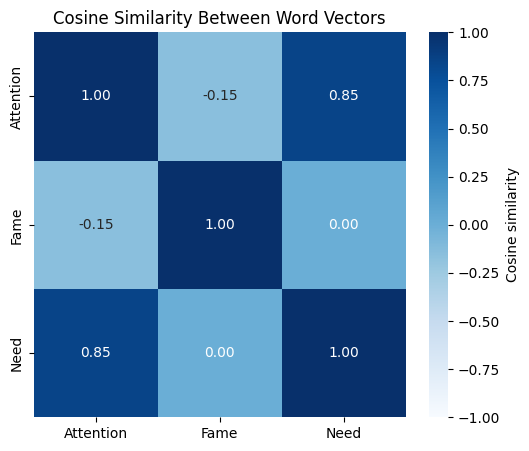

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import norm

# Token vectors
attention = np.array([2, 1, 0, 1, 1])
fame = np.array([-1, -1, 0, 2, 0])
need = np.array([1, 1, 1, 1, 1])
tokens = {"Attention": attention, "Fame": fame, "Need": need}

# Compute cosine similarity matrix
def cosine_similarity(a, b):
    return np.dot(a, b) / (norm(a) * norm(b))

labels = list(tokens.keys())
n = len(labels)
cos_sim_matrix = np.zeros((n, n))

for i, (t1, v1) in enumerate(tokens.items()):
    for j, (t2, v2) in enumerate(tokens.items()):
        cos_sim_matrix[i, j] = cosine_similarity(v1, v2)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    cos_sim_matrix, annot=True, fmt=".2f",
    xticklabels=labels, yticklabels=labels,
    cmap="Blues", vmin=-1, vmax=1, cbar_kws={"label": "Cosine similarity"}
)
plt.title("Cosine Similarity Between Word Vectors")
plt.show()

Let's drill down on how attention is actually computed.  

In a given layer of a Transformer model, our $N$ tokens—each represented by a $D$-dimensional feature vector—are stored as a matrix:

$$
\mathbf{X} \in \mathbb{R}^{N \times D}
$$

To compute attention, we form **three learned representations** of these tokens:

$$
\mathbf{Q} = \mathbf{X}\mathbf{W}_Q,
\quad
\mathbf{K} = \mathbf{X}\mathbf{W}_K,
\quad
\mathbf{V} = \mathbf{X}\mathbf{W}_V
$$

where:
- $\mathbf{W}_Q, \mathbf{W}_K, \mathbf{W}_V \in \mathbb{R}^{D \times D}$ are learnable parameter matrices  
- $\mathbf{Q}$, $\mathbf{K}$, and $\mathbf{V}$ denote the resulting **queries**, **keys**, and **values**

---

The attention mechanism asks: **how similar are the queries and the keys?**  
We answer this by computing a **dot product** between every query and every key:

$$
\mathbf{Q}\mathbf{K}^\top =
\begin{bmatrix}
\mathbf{q}_1 \!\cdot\! \mathbf{k}_1 & \mathbf{q}_1 \!\cdot\! \mathbf{k}_2 & \cdots & \mathbf{q}_1 \!\cdot\! \mathbf{k}_N \\
\mathbf{q}_2 \!\cdot\! \mathbf{k}_1 & \mathbf{q}_2 \!\cdot\! \mathbf{k}_2 & \cdots & \mathbf{q}_2 \!\cdot\! \mathbf{k}_N \\
\vdots & \vdots & \ddots & \vdots \\
\mathbf{q}_N \!\cdot\! \mathbf{k}_1 & \mathbf{q}_N \!\cdot\! \mathbf{k}_2 & \cdots & \mathbf{q}_N \!\cdot\! \mathbf{k}_N
\end{bmatrix}
$$

This matrix simply stores the **pairwise similarities** between all queries and keys.  
Importantly, these representations are *learned* — the model discovers the most useful notion of “similarity” for the task at hand.

---

To compute attention in full, we normalize each row of this similarity matrix with a softmax:

$$
\text{Attention}(\mathbf{Q}, \mathbf{K})
= \texttt{Softmax}\!\left(\frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{D}}\right)
$$

The factor of $1/\sqrt{D}$ normalizes the magnitude of the dot products, keeping the **temperature** of the softmax stable (since softmax is highly sensitive to input scale).

---

Each row of this matrix sums to 1.  
The entry in row $i$, column $j$ represents **how much token $i$ attends to token $j$** — in other words, how much information token $i$ gathers from token $j$.

Note that this matrix is **not symmetric**: token $j$ may give a very different amount of attention to token $i$.

---

**Steps:**
1. Compute pairwise similarities: $QK^\top$  
   → how aligned each query is with each key  
2. Scale by $\sqrt{D}$ to stabilize gradients  
3. Apply $\text{softmax}$ to get attention weights (probabilities that sum to 1)




> **EXERCISE 1**: Fill in the missing code in the cell below to compute an attention matrix. Verify that its rows sum to 1.

In [7]:
# EXERCISE

import torch
import torch.nn.functional as F

# -----------------------------
# Toy example: 4 tokens, 3D features
# -----------------------------
torch.manual_seed(0)
N, D = 4, 3  # 4 tokens, each 3-dimensional
X = torch.randn(N, D)
print("Input tokens (X):\n", X, "\n")

# -----------------------------
# Learned projection matrices (for demonstration only)
# -----------------------------
W_Q = torch.randn(D, D)
W_K = torch.randn(D, D)
W_V = torch.randn(D, D)

# Compute Queries, Keys, and Values
Q = X @ W_Q
K = X @ W_K
V = X @ W_V

print("Q:\n", Q, "\n")
print("K:\n", K, "\n")
print("V:\n", V, "\n")

# -----------------------------
# 1) Compute similarity scores
# -----------------------------
scores = Q @ K.T
print("Raw dot-product similarities (QK^T):\n", scores, "\n")

# -----------------------------
# 2) Scale by sqrt(D)
# -----------------------------
norm_factor = np.sqrt(D)
scaled_scores = scores / norm_factor

# -----------------------------
# 3) Apply softmax row-wise
# -----------------------------
attn_weights = F.softmax(scaled_scores, dim=-1)
print("Attention weights (softmax over rows):\n", attn_weights, "\n")

## VERIFY THAT ROWS SUM TO 1


Input tokens (X):
 tensor([[ 1.5410, -0.2934, -2.1788],
        [ 0.5684, -1.0845, -1.3986],
        [ 0.4033,  0.8380, -0.7193],
        [-0.4033, -0.5966,  0.1820]]) 

Q:
 tensor([[ 0.5873,  5.1502, -2.5672],
        [ 0.6275,  3.3504, -1.5316],
        [ 0.3989,  1.0548, -0.3858],
        [ 0.1100, -0.3807,  0.2769]]) 

K:
 tensor([[ 3.9118,  1.1229,  3.1381],
        [ 1.7263, -0.8072,  2.8448],
        [ 1.3173,  1.4532, -0.2521],
        [-0.8460, -1.1369,  0.3266]]) 

V:
 tensor([[ 2.8835, -0.2805, -0.3757],
        [ 1.1463,  2.3606, -0.5541],
        [ 1.4047, -2.0286,  0.0979],
        [-0.7205,  1.7620, -0.1822]]) 

Raw dot-product similarities (QK^T):
 tensor([[  0.0246, -10.4465,   8.9051,  -7.1906],
        [  1.4106,  -5.9783,   6.0815,  -4.8401],
        [  1.5340,  -1.2604,   2.1555,  -1.6626],
        [  0.8714,   1.2848,  -0.4783,   0.4303]]) 

Attention weights (softmax over rows):
 tensor([[5.8978e-03, 1.3969e-05, 9.9400e-01, 9.1529e-05],
        [6.3003e-02, 8.844

**Steps:**
1. Compute pairwise similarities: $QK^\top$  
   → how aligned each query is with each key  
2. Scale by $\sqrt{D}$ to stabilize gradients  
3. Apply $\text{softmax}$ to get attention weights (probabilities that sum to 1)

...now what do we do with attention scores?

4. **Use those weights to take a weighted sum of the value vectors $V$**

$$
  \text{Output} = \text{Attention}(\mathbf{Q}, \mathbf{K}) \times \mathbf{V}
$$

To be clear, the attention matrix tells us how much we should weight the corresponding entries of the **value** matrix.

In [8]:
# -----------------------------
# 4) Compute attention output
# -----------------------------
attn_output = attn_weights @ V
print("Attention output (weighted sum of V):\n", attn_output)

Attention output (weighted sum of V):
 tensor([[ 1.4132, -2.0179,  0.0950],
        [ 1.4940, -1.9081,  0.0670],
        [ 1.7961, -0.8735, -0.1344],
        [ 1.2629,  0.8996, -0.3355]])



---



In Transformers:
- Each token’s embedding generates its own $Q$, $K$, and $V$.  
- The attention scores decide *how much information to pull* from each other token.  
- **Multi-head attention** repeats this process in parallel with multiple sets of $(W_Q, W_K, W_V)$ to capture diverse relationships, then concatenates and linearly projects the results.


## 3. Fine-tuning

We've got pre-trained models like BERT available to us. These models have been trained on massive corpora and have excellent general language capabilities. Fine tuning is the process of tuning a pre-trained model, which is a much more efficient approach than re-tuning a language model from scratch.

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import torch

!pip install evaluate
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.0 MB/s eta 0:00:00




**DistilBERT** is a smaller, faster version of BERT trained through **knowledge distillation** — where a large **teacher** model (BERT) teaches a smaller **student** model to mimic its behavior.

- ~40% fewer parameters, ~60% faster inference  
- Retains ~97% of BERT’s performance on NLP benchmarks  
- Uses **6 Transformer layers** (vs. 12 in BERT-base)  

DistilBERT is trained to perform **masked language modeling** (like BERT); mask random words in a sentence, ask the model to predict them.

In [10]:
# Load tokenizer and model
model_name = "distilbert-base-uncased" # "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Binary classification

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 🎬 The IMDb Dataset

The [IMDb dataset](https://huggingface.co/datasets/stanfordnlp/imdb) contains **50,000 movie reviews**, each labeled for **sentiment analysis** —  
`0` for *negative* and `1` for *positive* sentiment.

These reviews are preprocessed as sequences of tokens and used to train models to perform **sentiment analysis**, that is to **detect emotional tone** present in language.

For example, what label do you think this review would have?

> *“National Treasure is about as over-rated and over-hyped as they come. Nicholas Cage is in no way a believable action hero, and this film is no 'Indiana Jones'. People who have compared this movie to the Indiana Jones classic trilogy have seriously fallen off their rocker...”*

Pretty clearly **negative**, right?  
That’s exactly the kind of reasoning a sentiment classifier learns to reproduce.

In [11]:
# Load IMDb dataset
dataset = load_dataset("imdb")

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [12]:
# Take a small fraction of the dataset (e.g., 10%)
fraction = 0.1
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(int(len(dataset["train"]) * fraction)))
small_test_dataset = dataset["test"].shuffle(seed=42).select(range(int(len(dataset["test"]) * fraction)))

# Verify the size
print(f"Train size: {len(small_train_dataset)}, Test size: {len(small_test_dataset)}")

# Tokenize the smaller datasets
def preprocess_data(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

small_train_dataset = small_train_dataset.map(preprocess_data, batched=True)
small_test_dataset = small_test_dataset.map(preprocess_data, batched=True)

# Convert to PyTorch format
small_train_dataset = small_train_dataset.rename_column("label", "labels")
small_test_dataset = small_test_dataset.rename_column("label", "labels")

small_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
small_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Train size: 2500, Test size: 2500


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [13]:
import torch

# Function to move tensors to the correct device (GPU/CPU)
def move_to_device(batch):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Move tensor columns to the correct device
    batch = {key: value.to(device) if torch.is_tensor(value) else value for key, value in batch.items()}
    return batch

# Apply this function to your dataset using `map`
small_train_dataset = small_train_dataset.map(move_to_device, batched=True)
small_test_dataset = small_test_dataset.map(move_to_device, batched=True)

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [14]:
model = model.to("cuda" if torch.cuda.is_available() else "cpu")
print("Model device:", next(model.parameters()).device)  # This should print "cuda" if using GPU

Model device: cuda:0


In [15]:
import os
os.environ["WANDB_DISABLED"] = "true"

from transformers import TrainingArguments

accuracy = evaluate.load("accuracy")

from sklearn.metrics import accuracy_score

def compute_metrics(p):
    predictions, labels = p
    preds = predictions.argmax(axis=-1)  # Get the class with the highest probability
    return accuracy.compute(predictions=preds, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    #evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    logging_steps=10,
    report_to=None,
    fp16=torch.cuda.is_available(),  # Enable mixed precision if on GPU
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-3148218792.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,0.686600
20,0.641100
30,0.504200
40,0.621000
50,0.403600
60,0.491400
70,0.401700
80,0.421300
90,0.420500
100,0.348700


TrainOutput(global_step=1570, training_loss=0.09555649186965007, metrics={'train_runtime': 225.7183, 'train_samples_per_second': 110.758, 'train_steps_per_second': 6.956, 'total_flos': 827921241600000.0, 'train_loss': 0.09555649186965007, 'epoch': 10.0})

In [16]:
results = trainer.evaluate()
print(results)

{'eval_loss': 1.1548799276351929, 'eval_accuracy': 0.834, 'eval_runtime': 2.4577, 'eval_samples_per_second': 1017.211, 'eval_steps_per_second': 32.144, 'epoch': 10.0}


## 4. Solutions to Exercises

**EXERCISE 1**

Simply run the cell below.

In [ ]:
# EXERCISE

import torch
import torch.nn.functional as F

# -----------------------------
# Toy example: 4 tokens, 3D features
# -----------------------------
torch.manual_seed(0)
N, D = 4, 3  # 4 tokens, each 3-dimensional
X = torch.randn(N, D)
print("Input tokens (X):\n", X, "\n")

# -----------------------------
# Learned projection matrices (for demonstration only)
# -----------------------------
W_Q = torch.randn(D, D)
W_K = torch.randn(D, D)
W_V = torch.randn(D, D)

# Compute Queries, Keys, and Values
Q = X @ W_Q
K = X @ W_K
V = X @ W_V

print("Q:\n", Q, "\n")
print("K:\n", K, "\n")
print("V:\n", V, "\n")

# -----------------------------
# 1) Compute similarity scores
# -----------------------------
scores = Q @ K.T
print("Raw dot-product similarities (QK^T):\n", scores, "\n")

# -----------------------------
# 2) Scale by sqrt(D)
# -----------------------------
scaled_scores = scores / torch.sqrt(torch.tensor(D, dtype=torch.float32))

# -----------------------------
# 3) Apply softmax row-wise
# -----------------------------
attn_weights = F.softmax(scaled_scores, dim=-1)
print("Attention weights (softmax over rows):\n", attn_weights, "\n")